<a href="https://colab.research.google.com/github/mnassrib/prediction-of-house-prices/blob/master/prediction_of_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://www.reno.gov/Home/ShowImage?id=7739&t=635620964226970000)

**Competition Description from Kaggle**  
With 80 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa in USA, the aim here is to predict the sale price of each home.

Therefore, we will practice feature engineering and regression algorithms to achieve the lowest prediction error (RMSE is the metric used in a such competition).

- <a href='#1'>1. Exploratory Data Analysis</a>
- <a href='#2'>2. Data Cleaning</a>
- <a href='#3'>3. Feature Engineering</a>
- <a href='#4'>4. Encoding Categorical Features</a>
- <a href='#5'>5. Detecting Outliers</a>
- <a href='#6'>6. Building Machine Learning Models</a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore')

Run this cell and select the kaggle.json file downloaded from the Kaggle account settings page.

In [0]:
from google.colab import files
files.upload()

{}

Let's make sure the kaggle.json file is present.

In [0]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Jan  8 13:19 kaggle.json


Next, install the Kaggle API client.

In [0]:
!pip install -q kaggle

The Kaggle API client expects this file to be in ~/.kaggle, so move it there.

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

kaggle.json


This permission change avoids a warning on Kaggle tool startup.

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

Download the dataset from Kaggle by copying the API datasets here

In [0]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 27.0MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.2MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 61.2MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 61.6MB/s]


# <a id='1'>1. Exploratory Data Analysis</a>

In [0]:
a = pd.read_csv('/content/train.csv')
b = pd.read_csv('/content/test.csv')

print('The shape of the training set:', a.shape[0], 'houses and', a.shape[1], 'features.')
print('The shape of the testing set:', b.shape[0], 'houses and', b.shape[1], 'features.')
print('The testing set has 1 feature less than the training set which is the target (SalePrice) to predict.')

The shape of the training set: 1460 houses and 81 features.
The shape of the testing set: 1459 houses and 80 features.
The testing set has 1 feature less than the training set which is the target (SalePrice) to predict.


Here is a glimpse of what we will be dealing with:
* Many features, 
* Many missing values, 
* One target feature: ``SalePrice`` which is the price of the houses we are supposed to predict.

In [0]:
a.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Let's have a look first at the correlation between numerical features and the target ``SalePrice``, in order to have a first idea of the connections between features.

*It is not necessary to include the ``Id`` feature into the analysis!*

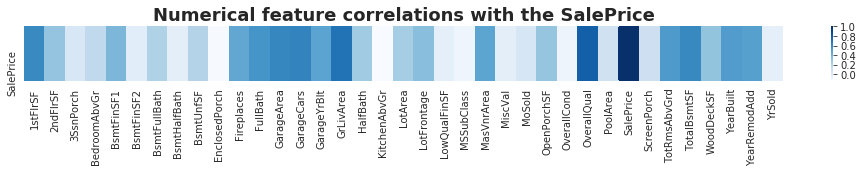

In [0]:
num = a.select_dtypes(exclude='object')
numcorr = num[num.columns.difference(['Id'])].corr()
f, ax = plt.subplots(figsize=(17,1))
sns.heatmap(numcorr.sort_values(by=['SalePrice'], ascending=False).head(1), cmap='Blues')
plt.title("Numerical feature correlations with the SalePrice", weight='bold', fontsize=18)
plt.show()

Just by looking at the heatmap above we can see many dark colors. Indeed, many features have high correlation with the target.

To have a better idea, we sort the features according to their correlations with the ``SalePrice``.

In [0]:
def stylerfunc(df): 
    return df.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

In [0]:
stylerfunc(numcorr['SalePrice'].sort_values(ascending=False).head(10).to_frame().T)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt
SalePrice,1,0.790982,0.708624,0.640409,0.623431,0.613581,0.605852,0.560664,0.533723,0.522897


The **overall quality**, **the living area, basement area, garage cars and garage area** have the highest correlation values with the sale price, which is logical, better quality and bigger area = Higher price.
* Also some features such as, **full bath** or **1st floor surface** have a higher correlation, those are luxury features, more luxury = Higher price.
* and **Year built**, the newer buildings seem to have higher sale prices.

Let's dig in more into the data, those are just the numerical features. I assume that categorical features will be very important, for example, the neighborhood feature will be important, maybe the most important, given that good locations nowadays cost good money.

But before going any further, we start by cleaning the data from missing values. For this, let's investigate and identify features with missing values.

In [0]:
def mvrateplot(df, title):
    df = df.drop(df[df == 0].index).sort_values(ascending=True)
    plt.figure(figsize=(10, 6))
    df.plot.barh(color='purple')
    plt.title(title, fontsize=20, weight='bold' )
    plt.show()

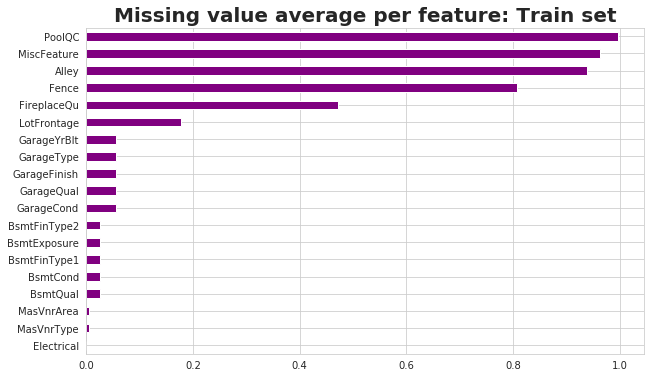

In [0]:
mvrateplot(a.isnull().mean(),'Missing value average per feature: Train set')

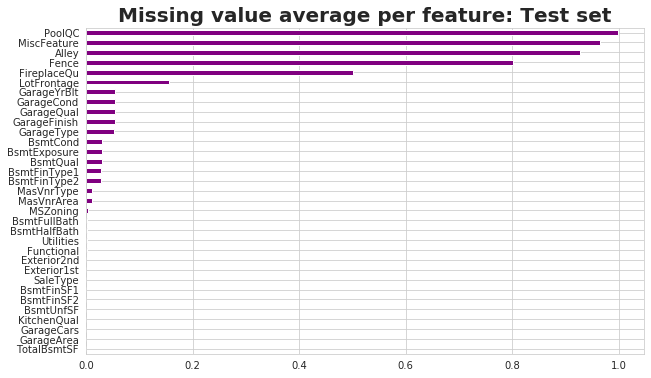

In [0]:
mvrateplot(b.isnull().mean(),'Missing value average per feature: Test set')

> Most of the features are clean from missing values

**We combine first the train and test datasets to run all the data munging and applying feature engineering on both of them.**

In [0]:
trainsize = a.shape[0] # the length of the train raw data set
testsize = b.shape[0]  # the length of the test raw data set
y_train = a['SalePrice'].to_frame()
#Combine train and test sets
c = pd.concat((a, b), sort=False).reset_index(drop=True)
c.name = 'c'
#Drop the target "SalePrice" and Id columns
c.drop(['SalePrice'], axis=1, inplace=True)
c.drop(['Id'], axis=1, inplace=True)
print(f"Total size of the combined dataframe {c.name} is:", c.shape)
oldlen = c.shape[1]
oldset = set(c)

Total size of the combined dataframe c is: (2919, 79)


# <a id='2'>2. Data Cleaning</a>

> First thing to do is get rid of the features with more than 90% missing values. For example the PoolQC's missing values are probably due to the lack of pools in some buildings, which is very logical. But replacing those (more than 90%) missing values with "no pool" will leave us with a feature with low variance, and low variance features are uniformative for machine learning models. So we drop the features with more than 90% missing values.

In [0]:
c = c.dropna(thresh = len(c)*0.9, axis=1)
c.name = 'c'
print(oldlen-c.shape[1], 'features with each more than 90% of missing values are dropped from the combined dataset.')
print('The dropped features are:', list(oldset-set(c)))
print(f"--> Total size of the combined dataset {c.name} after dropping features with more than 90% M.V.:",c.shape)

6 features with each more than 90% of missing values are dropped from the combined dataset.
The dropped features are: ['MiscFeature', 'Fence', 'Alley', 'LotFrontage', 'FireplaceQu', 'PoolQC']
--> Total size of the combined dataset c after dropping features with more than 90% M.V.: (2919, 73)


Before cleaning the data, we zoom at the features with missing values which won't be treated iqually. Some features have barely 1 or 2 missing values, we will use the forward fill method to fill them.

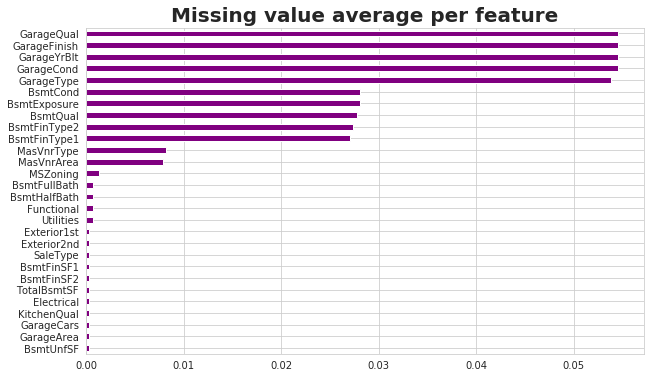

In [0]:
mvrateplot((c.isnull().sum()/len(c)), 'Missing value average per feature')

We isolate the missing values from the rest of the dataset to have a good idea of how to treat them. 

Let's create a NA dataframe composed of only features with M.V. Then, we split them to:
* Categorical features
* Numerical features

In [0]:
allna = (c.isnull().sum()/len(c))
allna = allna.drop(allna[allna == 0].index).sort_values(ascending=False)

NA = c[allna.index]
NAcat = NA.select_dtypes(include='object')
NAnum = NA.select_dtypes(exclude='object')
print(f'There are {NAcat.shape[1]} categorical features with missing values')
print(f'There are {NAnum.shape[1]} numerical features with missing values')

There are 18 categorical features with missing values
There are 10 numerical features with missing values


As we can see, there are 18 categorical features and 10 numerical features to clean.

We start with the numerical features. First thing to do is to have a look at them to learn more about their distribution and decide how to clean them:
- Most of the features are going to be filled with 0s because we assume that they don't exist, for example GarageArea, GarageCars with missing values are simply because the house lacks a garage.
- GarageYrBlt: Year garage was built can't be filled with 0s, so we fill with the median (1979).

In [0]:
NAnum.head()

,GarageYrBlt,MasVnrArea,BsmtFullBath,BsmtHalfBath,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,GarageCars,GarageArea,BsmtUnfSF
0,2003.0,196.0,1.0,0.0,706.0,0.0,856.0,2.0,548.0,150.0
1,1976.0,0.0,0.0,1.0,978.0,0.0,1262.0,2.0,460.0,284.0
2,2001.0,162.0,1.0,0.0,486.0,0.0,920.0,2.0,608.0,434.0
3,1998.0,0.0,1.0,0.0,216.0,0.0,756.0,3.0,642.0,540.0
4,2000.0,350.0,1.0,0.0,655.0,0.0,1145.0,3.0,836.0,490.0


* ``MasVnrArea``: (Masonry veneer area) is in square feet, the missing data means no veneer so we fill with 0.
* ``GarageYrBlt`` (Year garage was built), we fill the gaps with the median: 1979.
* For the rest of the columns: Bathroom, half bathroom, basement related columns and garage related columns, we will fill with 0's because they just mean that the hosue doesn't have a basement, bathrooms or a garage.

In [0]:
c['MasVnrArea'] = c.MasVnrArea.fillna(0)

c['GarageYrBlt'] = c["GarageYrBlt"].fillna(c["GarageYrBlt"].median())

Concerning the 18 Categorical features with missing values:
* Some features have just 1 or 2 missing values, so we will just use the forward fill method because they are obviously values that can't be filled with 'None's
* Features with many missing values are mostly basement and garage related (same as in numerical features) so as we did with numerical features (filling them with 0s), we will fill the categorical missing values with 'None's assuming that the houses lack basements and garages.

In [0]:
NAcat.head()

,GarageQual,GarageFinish,GarageCond,GarageType,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType2,BsmtFinType1,MasVnrType,MSZoning,Functional,Utilities,Exterior1st,Exterior2nd,SaleType,Electrical,KitchenQual
0,TA,RFn,TA,Attchd,TA,No,Gd,Unf,GLQ,BrkFace,RL,Typ,AllPub,VinylSd,VinylSd,WD,SBrkr,Gd
1,TA,RFn,TA,Attchd,TA,Gd,Gd,Unf,ALQ,None,RL,Typ,AllPub,MetalSd,MetalSd,WD,SBrkr,TA
2,TA,RFn,TA,Attchd,TA,Mn,Gd,Unf,GLQ,BrkFace,RL,Typ,AllPub,VinylSd,VinylSd,WD,SBrkr,Gd
3,TA,Unf,TA,Detchd,Gd,No,TA,Unf,ALQ,None,RL,Typ,AllPub,Wd Sdng,Wd Shng,WD,SBrkr,Gd
4,TA,RFn,TA,Attchd,TA,Av,Gd,Unf,GLQ,BrkFace,RL,Typ,AllPub,VinylSd,VinylSd,WD,SBrkr,Gd


Let's display the number of missing values per categorical feature:

In [0]:
stylerfunc(NAcat.isnull().sum().head(18).to_frame().sort_values(by=[0]).T)

,KitchenQual,SaleType,Exterior2nd,Exterior1st,Electrical,Utilities,Functional,MSZoning,MasVnrType,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtExposure,BsmtCond,GarageType,GarageCond,GarageFinish,GarageQual
0,1,1,1,1,1,2,2,4,24,79,80,81,82,82,157,159,159,159


We start with categorical features having just few missing values, as example the number of M.V. less than 5. 

Lest's locate these features and then we fill the gap with forward fill method:

In [0]:
mvthreshold = 4

print(f'The categorical features having a number of M.V. less or equal to {mvthreshold}:\n', 
      list(NAcat.columns[NAcat.isnull().sum()<=mvthreshold]))

The categorical features having a number of M.V. less or equal to 4:
 ['MSZoning', 'Functional', 'Utilities', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Electrical', 'KitchenQual']


In [0]:
fewMVNAcat = list(NAcat.columns[NAcat.isnull().sum()<=mvthreshold])
for f in fewMVNAcat:
    c[f] = c[f].fillna(method='ffill')

Let's check if these categorical features do not yet have M.V.

In [0]:
stylerfunc(c[fewMVNAcat].isnull().sum().to_frame().sort_values(by=[0]).T)

,MSZoning,Functional,Utilities,Exterior1st,Exterior2nd,SaleType,Electrical,KitchenQual
0,0,0,0,0,0,0,0,0


* We already dealt with small missing values or values that can't be filled with "0" such as Garage year built.
* The rest of features are mostly basement and garage related with 100s of missing values, we will just fill 0s in the numerical features and 'None' in categorical features, assuming that the houses don't have basements, full bathrooms or garage.

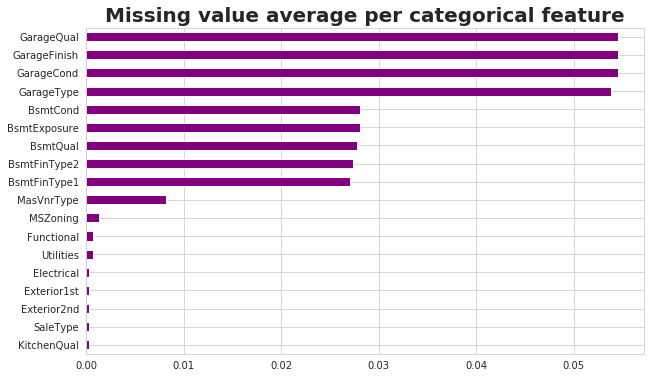

In [0]:
mvrateplot((NAcat.isnull().sum()/len(NAcat)), 'Missing value average per categorical feature')

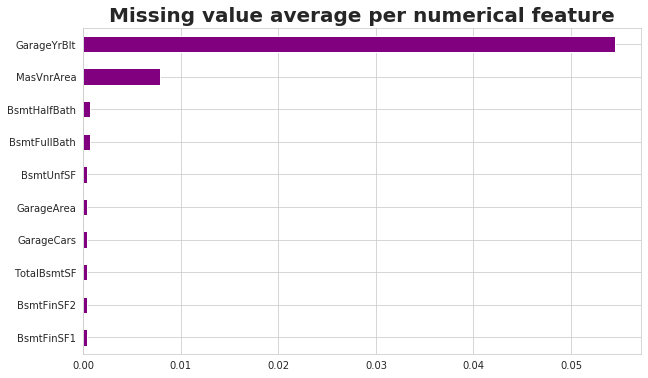

In [0]:
mvrateplot((NAnum.isnull().sum()/len(NAnum)), 'Missing value average per numerical feature')

Now for the rest of features, we will just fill 0s in the numerical features and 'None' in categorical features, assuming that the houses don't have basements, full bathrooms or garage.

In [0]:
for col in NA.columns:
    if c[col].dtype == "object":
        c[col] = c[col].fillna("None")
    else:
        c[col] = c[col].fillna(0)

Checking if the dataframe ``c`` contains yet missing values:

In [0]:
c.isnull().sum().sort_values(ascending=False).head()

SaleCondition    0
TotalBsmtSF      0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64

We finally end up with a clean dataset, next thing to do is create new features.

# <a id='3'>3. Feature Engineering</a>

Since the area is a very important variable, we will create a new feature "**TotalArea**" that sums the area of all the floors and the basement.
* **Bathrooms**: All the bathroom in the ground floor
* **Year average**: The average of the sum of the year in which the house was built and the year the house was remodeled.

In [0]:
c['TotalArea'] = c['TotalBsmtSF'] + c['1stFlrSF'] + c['2ndFlrSF'] + c['GrLivArea'] + c['GarageArea']

c['Bathrooms'] = c['FullBath'] + c['HalfBath']*0.5 

c['YearAverage'] = (c['YearRemodAdd'] + c['YearBuilt'])/2

Feature engineering is very important to improve the model's performance, I will start in this kernel just with the TotalArea, Bathrooms and average year features and will keep updating the kernel by creating new features.

# <a id='4'>4. Encoding Categorical Features</a>

In [0]:
cb = pd.get_dummies(c) 
print("The shape of the original dataset:", c.shape)
print("The shape of the encoded dataset:", cb.shape)
print(f'--> {cb.shape[1] - c.shape[1]} encoded features are added to the combined dataset.')

The shape of the original dataset: (2919, 76)
The shape of the encoded dataset: (2919, 281)
--> 205 encoded features are added to the combined dataset.


We are done with the cleaning, normalization and feature engineering. Now, we split the combined dataset to the original train and test sets.

In [0]:
Train = cb[:trainsize]  #trainsize is the number of rows of the original training set
Test = cb[trainsize:] 
print("The shape of train dataset:", Train.shape)
print("The shape of test dataset:", Test.shape)

The shape of train dataset: (1460, 281)
The shape of test dataset: (1459, 281)


# <a id='5'>5. Detecting Outliers</a>

This part of the kernel will be a little bit messy. I didn't want to deal with the outliers in the combined dataset to keep the shape of the original train and test datasets. Dropping them would shift the location of the rows.

So we go back to our original train dataset to visualize the important features / Sale price scatter plots to find outliers

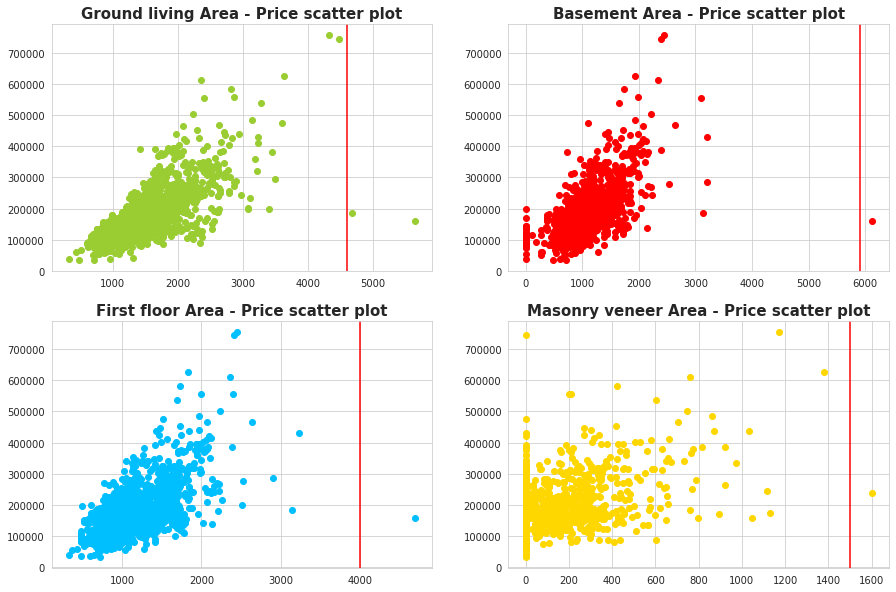

In [0]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2),(0,0))
plt.scatter(x=a['GrLivArea'], y=a['SalePrice'], color=('yellowgreen'))
plt.axvline(x=4600, color='r', linestyle='-')
plt.title('Ground living Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((2,2),(0,1))
plt.scatter(x=a['TotalBsmtSF'], y=a['SalePrice'], color=('red'))
plt.axvline(x=5900, color='r', linestyle='-')
plt.title('Basement Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((2,2),(1,0))
plt.scatter(x=a['1stFlrSF'], y=a['SalePrice'], color=('deepskyblue'))
plt.axvline(x=4000, color='r', linestyle='-')
plt.title('First floor Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((2,2),(1,1))
plt.scatter(x=a['MasVnrArea'], y=a['SalePrice'], color=('gold'))
plt.axvline(x=1500, color='r', linestyle='-')
plt.title('Masonry veneer Area - Price scatter plot', fontsize=15, weight='bold' )
plt.show()

The outliers are the points in the right that have a larger area but a very low sale price. We localize those points by sorting their respective columns

* The outlier in "basement" and "first floor" features is the same as the first outlier in ground living area: **the outlier with index number 1298. **
* We detect the outlier 297 in MasVnrArea.

In [0]:
print(a['GrLivArea'].sort_values(ascending=False).head(2))
print('*'*30)
print(a['TotalBsmtSF'].sort_values(ascending=False).head(1))
print('*'*30)
print(a['MasVnrArea'].sort_values(ascending=False).head(1))
print('*'*30)
print(a['1stFlrSF'].sort_values(ascending=False).head(1))

1298    5642
523     4676
Name: GrLivArea, dtype: int64
******************************
1298    6110
Name: TotalBsmtSF, dtype: int64
******************************
297    1600.0
Name: MasVnrArea, dtype: float64
******************************
1298    4692
Name: 1stFlrSF, dtype: int64


We can safety remove those 3 outliers by creating a new dataframe without these index (297, 523, 1298)  

In [0]:
train = Train[(Train['GrLivArea'] < 4600) & (Train['MasVnrArea'] < 1500)]

print(f'--> {Train.shape[0]-train.shape[0]} outliers are removed from the train dataset.')

--> 3 outliers are removed from the train dataset.


We do with the same thing with ``SalePrice`` feature, we localize those rows with these index (297, 523, 1298) and make sure they are the right outliers to remove. 

In [0]:
target = a[['SalePrice']]
outliers = [1298, 523, 297]
target.drop(target.index[outliers], inplace=True)

In [0]:
print('Make sure that both train and target sets have the same row number after removing the outliers:')
print('Train:', train.shape[0], 'rows')
print('Target:', target.shape[0], 'rows')

Make sure that both train and target sets have the same row number after removing the outliers:
Train: 1457 rows
Target: 1457 rows


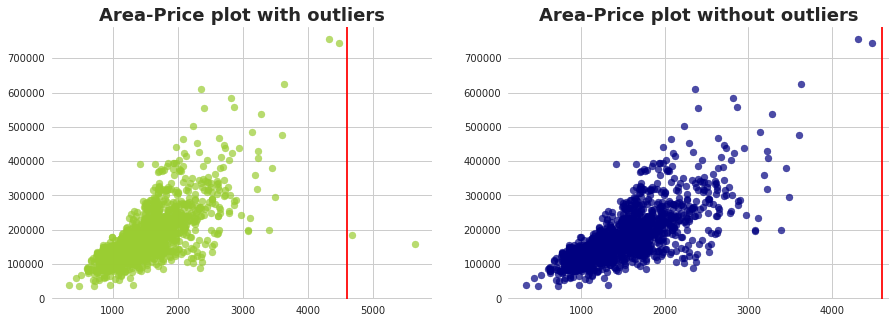

In [0]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((1,2),(0,0))
plt.scatter(x=a['GrLivArea'], y=a['SalePrice'], color=('yellowgreen'), alpha=0.7)
plt.title('Area-Price plot with outliers',weight='bold', fontsize=18)
plt.axvline(x=4600, color='r', linestyle='-')
#first row, second col
ax1 = plt.subplot2grid((1,2),(0,1))
plt.scatter(x=train['GrLivArea'], y=target['SalePrice'], color='navy', alpha=0.7)
plt.axvline(x=4600, color='r', linestyle='-')
plt.title('Area-Price plot without outliers',weight='bold', fontsize=18)
plt.show()

> ### Log tranform the target because it's skewed to the right

We will apply **np.log1p** to the skewed features. (To get the original values back, we will apply **np.expm1** at the end of the study after training and testing the models. 

In [0]:
target["SalePrice"] = np.log1p(target["SalePrice"])

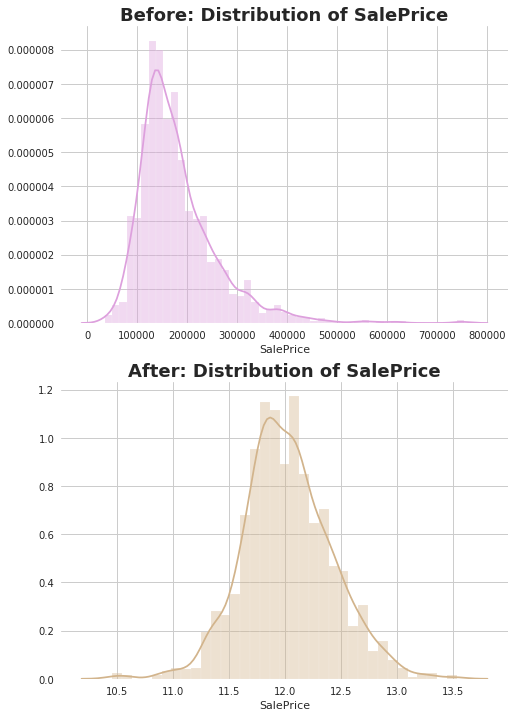

In [0]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,12))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((2,1),(0,0))
sns.distplot(np.expm1(target["SalePrice"]), color='plum')
plt.title('Before: Distribution of SalePrice',weight='bold', fontsize=18)
#first row, second col
ax1 = plt.subplot2grid((2,1),(1,0))
sns.distplot(target["SalePrice"], color='tan')
plt.title('After: Distribution of SalePrice',weight='bold', fontsize=18)
plt.show()

# <a id='6'>6. Building Machine Learning Models</a>

In [0]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor
import math
import time

## Preprocessing
We start machine learning by setting the features and target:
* Features: x
* Target: y

In [0]:
print(train.shape)
print(target.shape)
print(Test.shape)

(1457, 281)
(1457, 1)
(1459, 281)


In [0]:
x = train
y = np.array(target)

Splitting the data to train and test datasets

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .33, random_state=0)

RobustScaler can be used to scale the data because it's powerful against outliers, we already detected some but there must be some other outliers out there.

In [0]:
scaler = RobustScaler()
# transform "x_train"
x_train = scaler.fit_transform(x_train)
# transform "x_test"
x_test = scaler.transform(x_test)
# transform "x"
x = scaler.transform(x)
# transform the test set
X_test = scaler.transform(Test)

In [0]:
def GridSearchCVmodels(modellist, x_train, y_train, x_test, y_test, x, y, cv): 
    results = {}
    bestregressors = {}
    for regmodel in modellist:
        vars()["grid_%s"%regmodel.__name__] = GridSearchCV(estimator=regmodel(), 
                                                           param_grid=param_grid.get(regmodel.__name__),
                                                           cv=cv, scoring='neg_mean_squared_error', verbose=0, 
                                                           n_jobs=-1, return_train_score=True, iid=False).fit(x_train, y_train.ravel())
        print(f'Regressor {modellist.index(regmodel)+1}/{len(modellist)}:')
        print("-> Best Mean RMSE: %f using %s with %s" % (-vars()["grid_%s"%regmodel.__name__].best_score_, 
                                                          regmodel.__name__, 
                                                          vars()["grid_%s"%regmodel.__name__].best_params_))

        results[regmodel.__name__] = [-max(vars()["grid_%s"%regmodel.__name__].cv_results_['mean_train_score']),
                                      -max(vars()["grid_%s"%regmodel.__name__].cv_results_['mean_test_score']),
                                      np.sqrt(mean_squared_error(vars()["grid_%s"%regmodel.__name__].best_estimator_.predict(x_train), y_train)),
                                      np.sqrt(mean_squared_error(vars()["grid_%s"%regmodel.__name__].best_estimator_.predict(x_test), y_test)), 
                                      np.sqrt(mean_squared_error(vars()["grid_%s"%regmodel.__name__].best_estimator_.predict(x), y)), 
                                     ]
        
        bestregressors[regmodel.__name__] = vars()["grid_%s"%regmodel.__name__].best_estimator_
    
    return results, bestregressors

In [0]:
param_grid_Ridge = {'alpha': np.arange(10.4, 10.6, 0.01), 
                    'fit_intercept': [True, False],
                   }

param_grid_Lasso = {'alpha': np.arange(4.2, 4.4, 0.01)*1e-4,
                    'fit_intercept': [True, False],
                   }

param_grid_ElasticNet = {'random_state': [1],
                         'alpha': np.arange(34, 35, 0.1)*1e-04,
                         'l1_ratio': np.arange(84, 85, 0.1)*1e-03,
                         'fit_intercept': [True, False], 
                        }

param_grid_XGBRegressor = {'objective': ['reg:squarederror'],
                           'gamma': [0], #np.arange(0, 10, 1), 
                           'n_estimators': [4110], #np.arange(4000, 4500, 100),  
                           'learning_rate': [0.01],
                           'seed': [27],
                          }

param_grid = {"Ridge": param_grid_Ridge,
              "Lasso": param_grid_Lasso,
              "ElasticNet": param_grid_ElasticNet,
              "XGBRegressor": param_grid_XGBRegressor,
              }

modellist = [Ridge, Lasso, ElasticNet, XGBRegressor]

results, bestregressors = GridSearchCVmodels(modellist, x_train, y_train, x_test, y_test, x, y, cv=5)

pd.DataFrame(results, index=['SubSubTrainData', 'SubSubTestData', 'SubTrainData', 'SubTestData', 'AllTrainData']).transpose()

Regressor 1/4:
-> Best Mean RMSE: 0.013375 using Ridge with {'alpha': 10.509999999999998, 'fit_intercept': True}
Regressor 2/4:
-> Best Mean RMSE: 0.013120 using Lasso with {'alpha': 0.0004279999999999999, 'fit_intercept': True}
Regressor 3/4:
-> Best Mean RMSE: 0.013136 using ElasticNet with {'alpha': 0.0034400000000000008, 'fit_intercept': True, 'l1_ratio': 0.0842, 'random_state': 1}
Regressor 4/4:
-> Best Mean RMSE: 0.014894 using XGBRegressor with {'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 4110, 'objective': 'reg:squarederror', 'seed': 27}


,SubSubTrainData,SubSubTestData,SubTrainData,SubTestData,AllTrainData
Ridge,0.008390,0.013375,0.093357,0.115232,0.101104
Lasso,0.008414,0.013120,0.094539,0.114233,0.101464
ElasticNet,0.008373,0.013136,0.094312,0.115055,0.101629
XGBRegressor,0.001310,0.014894,0.041937,0.116296,0.075120


In [0]:
def VotingRegressorCV(estimators_list, vote_params, x_train, y_train, x_test, y_test, x, y, cv):
    estimator=VotingRegressor(estimators_list)
    grid = GridSearchCV(estimator,
                        param_grid=vote_params, 
                        cv=cv, scoring='neg_mean_squared_error', 
                        verbose=0, n_jobs=-1, return_train_score=True, iid=False).fit(x_train, y_train.ravel())

    print("-> Best Mean RMSE: %f using %s with %s" % (-grid.best_score_, 
                                                      type(estimator).__name__, 
                                                      grid.best_params_))
    
    results['%s'%type(estimator).__name__] = [-max(grid.cv_results_['mean_train_score']), 
                                              -max(grid.cv_results_['mean_test_score']), 
                                              np.sqrt(mean_squared_error(grid.best_estimator_.predict(x_train), y_train)), 
                                              np.sqrt(mean_squared_error(grid.best_estimator_.predict(x_test), y_test)), 
                                              np.sqrt(mean_squared_error(grid.best_estimator_.predict(x), y)), 
                                             ]
    return grid, results

In [0]:
estimators_list = [('Ridge', bestregressors['Ridge']),  
                   ('Lasso', bestregressors['Lasso']), 
                   ('ElasticNet', bestregressors['ElasticNet']), 
                   ('XGBRegressor', bestregressors['XGBRegressor']), 
                  ]

#Set parameters for GridSearch
vote_params = {'weights': [(1, 1, 1, 1),
                           #(0, 1, 1, 1), 
                           #(1, 0, 1, 1), 
                           #(1, 1, 0, 1),
                           #(1, 1, 1, 0),
                          ], 
              }

grid_VotingRegressor, results = VotingRegressorCV(estimators_list, vote_params, x_train, y_train, x_test, y_test, x, y, cv=5)

pd.DataFrame(results, index=['SubSubTrainData', 'SubSubTestData', 'SubTrainData', 'SubTestData', 'AllTrainData']).transpose()

-> Best Mean RMSE: 0.012527 using VotingRegressor with {'weights': (1, 1, 1, 1)}


,SubSubTrainData,SubSubTestData,SubTrainData,SubTestData,AllTrainData
Ridge,0.008390,0.013375,0.093357,0.115232,0.101104
Lasso,0.008414,0.013120,0.094539,0.114233,0.101464
ElasticNet,0.008373,0.013136,0.094312,0.115055,0.101629
XGBRegressor,0.001310,0.014894,0.041937,0.116296,0.075120
VotingRegressor,0.005665,0.012527,0.078372,0.110327,0.090182


In [0]:
def StackingRegressorCV(regressors, meta_regressor, params, x_train, y_train, x_test, y_test, x, y, cv):
    stackreg = StackingRegressor(regressors=regressors, meta_regressor=meta_regressor, use_features_in_secondary=True)
    
    grid = GridSearchCV(estimator=stackreg,
                        param_grid=params, 
                        cv=cv, scoring='neg_mean_squared_error', 
                        verbose=0, n_jobs=-1, return_train_score=True, iid=False).fit(x_train, y_train.ravel())

    print("-> Best Mean RMSE: %f using Stack_%s with %s" % (-grid.best_score_, 
                                                         type(meta_regressor).__name__, 
                                                         grid.best_params_))
    
    results['Stack_%s'%type(meta_regressor).__name__] = [-max(grid.cv_results_['mean_train_score']), 
                                                         -max(grid.cv_results_['mean_test_score']), 
                                                         np.sqrt(mean_squared_error(grid.best_estimator_.predict(x_train), y_train)), 
                                                         np.sqrt(mean_squared_error(grid.best_estimator_.predict(x_test), y_test)), 
                                                         np.sqrt(mean_squared_error(grid.best_estimator_.predict(x), y)), 
                                                        ]
    return grid, results

In [0]:
params = {'meta_regressor__alpha': [63.8], #np.arange(63.8, 63.9, 0.01)*1e-0, 
          'meta_regressor__fit_intercept': [False], #[True, False], 
         } 
          
grid_Stack_Ridge, results = StackingRegressorCV(regressors = [bestregressors['Lasso'], 
                                                              bestregressors['ElasticNet'], 
                                                              grid_VotingRegressor.best_estimator_, 
                                                             ], 
                                                meta_regressor = Ridge(), 
                                                params = params, x_train = x_train, 
                                                y_train = y_train, x_test = x_test, 
                                                y_test = y_test, x = x, y = y, cv=5) 
          
pd.DataFrame(results, index=['SubSubTrainData', 'SubSubTestData', 'SubTrainData', 'SubTestData', 'AllTrainData']).transpose()

-> Best Mean RMSE: 0.012998 using Stack_Ridge with {'meta_regressor__alpha': 63.8, 'meta_regressor__fit_intercept': False}


,SubSubTrainData,SubSubTestData,SubTrainData,SubTestData,AllTrainData
Ridge,0.008390,0.013375,0.093357,0.115232,0.101104
Lasso,0.008414,0.013120,0.094539,0.114233,0.101464
ElasticNet,0.008373,0.013136,0.094312,0.115055,0.101629
XGBRegressor,0.001310,0.014894,0.041937,0.116296,0.075120
VotingRegressor,0.005665,0.012527,0.078372,0.110327,0.090182
Stack_Ridge,0.007228,0.012998,0.087626,0.114206,0.097208


In [0]:
params = {'meta_regressor__random_state': [1],
          'meta_regressor__alpha': [0.0034], #np.arange(34, 35, 0.1)*1e-04,
          'meta_regressor__l1_ratio': [0.084], #np.arange(84, 85, 0.1)*1e-03,
          'meta_regressor__fit_intercept': [True, False],
         } 

grid_Stack_ElasticNet, results = StackingRegressorCV(regressors = [bestregressors['Ridge'], 
                                                                   bestregressors['Lasso'],  
                                                                   grid_VotingRegressor.best_estimator_, 
                                                                  ], 
                                                     meta_regressor = ElasticNet(), 
                                                     params = params, x_train = x_train, 
                                                     y_train = y_train, x_test = x_test, 
                                                     y_test = y_test, x = x, y = y, cv=5) 
          
pd.DataFrame(results, index=['SubSubTrainData', 'SubSubTestData', 'SubTrainData', 'SubTestData', 'AllTrainData']).transpose()

-> Best Mean RMSE: 0.012694 using Stack_ElasticNet with {'meta_regressor__alpha': 0.0034, 'meta_regressor__fit_intercept': True, 'meta_regressor__l1_ratio': 0.084, 'meta_regressor__random_state': 1}


,SubSubTrainData,SubSubTestData,SubTrainData,SubTestData,AllTrainData
Ridge,0.008390,0.013375,0.093357,0.115232,0.101104
Lasso,0.008414,0.013120,0.094539,0.114233,0.101464
ElasticNet,0.008373,0.013136,0.094312,0.115055,0.101629
XGBRegressor,0.001310,0.014894,0.041937,0.116296,0.075120
VotingRegressor,0.005665,0.012527,0.078372,0.110327,0.090182
Stack_Ridge,0.007228,0.012998,0.087626,0.114206,0.097208
Stack_ElasticNet,0.006482,0.012694,0.083637,0.111795,0.093871


In [0]:
params = {'meta_regressor__seed': [27],
          'meta_regressor__objective': ['reg:squarederror'],
          'meta_regressor__gamma': [0], #np.arange(8.7, 9.2, 0.1)*1e-04,
          'meta_regressor__n_estimators': [2500], #np.arange(72, 93, 5),
         }

grid_Stack_XGBRegressor, results = StackingRegressorCV(regressors = [bestregressors['Ridge'], 
                                                                     bestregressors['Lasso'], 
                                                                     bestregressors['ElasticNet'], 
                                                                     grid_VotingRegressor.best_estimator_, 
                                                                    ], 
                                                       meta_regressor = XGBRegressor(), 
                                                       params = params, x_train = x_train, 
                                                       y_train = y_train, x_test = x_test, 
                                                       y_test = y_test, x = x, y = y, cv=5)

pd.DataFrame(results, index=['SubSubTrainData', 'SubSubTestData', 'SubTrainData', 'SubTestData', 'AllTrainData']).transpose()

-> Best Mean RMSE: 0.013722 using Stack_XGBRegressor with {'meta_regressor__gamma': 0, 'meta_regressor__n_estimators': 2500, 'meta_regressor__objective': 'reg:squarederror', 'meta_regressor__seed': 27}


,SubSubTrainData,SubSubTestData,SubTrainData,SubTestData,AllTrainData
Ridge,0.008390,0.013375,0.093357,0.115232,0.101104
Lasso,0.008414,0.013120,0.094539,0.114233,0.101464
ElasticNet,0.008373,0.013136,0.094312,0.115055,0.101629
XGBRegressor,0.001310,0.014894,0.041937,0.116296,0.075120
VotingRegressor,0.005665,0.012527,0.078372,0.110327,0.090182
Stack_Ridge,0.007228,0.012998,0.087626,0.114206,0.097208
Stack_ElasticNet,0.006482,0.012694,0.083637,0.111795,0.093871
Stack_XGBRegressor,0.000003,0.013722,0.001867,0.110638,0.063588


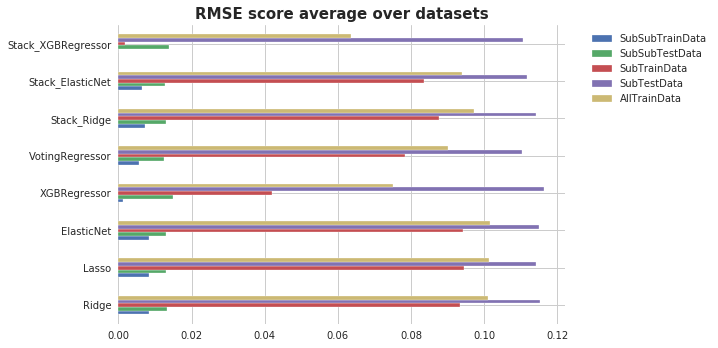

In [0]:
df_results = pd.DataFrame(results, index=['SubSubTrainData', 'SubSubTestData', 'SubTrainData', 
                                          'SubTestData', 'AllTrainData']).transpose()
df_results.plot.barh(rot=0)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("RMSE score average over datasets", weight='bold', fontsize=15)
plt.show()

In [0]:
def blend(df):
    blenddf = pd.DataFrame({#'a': bestregressors['Lasso'].predict(df),
                            'b': grid_VotingRegressor.best_estimator_.predict(df),
                            'c': grid_Stack_XGBRegressor.best_estimator_.predict(df), 
                           })
    return blenddf

linregtest = LinearRegression(fit_intercept='False', normalize='False').fit(blend(x_test), y_test)
print(linregtest.coef_)
print(np.sqrt(mean_squared_error(linregtest.predict(blend(x_test)), y_test)))

[[0.52265736 0.47965121]]
0.10793292245545996



If you like to discuss any other projects or just have a chat about data science topics, I'll be more than happy to connect with you on:

LinkedIn: https://www.linkedin.com/in/baligh-mnassri/

This kernel will always be a work in progress. If you have any idea/suggestions about this notebook, please let me know. Any feedback about further improvements would be genuinely appreciated.